In [62]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#import time
from multiprocessing import Pool, cpu_count
import emcee
import corner
from Corrfunc.theory.wp import wp
#import MCMC_data_file
from numpy.linalg import inv
#import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from math import floor,ceil
from tabcorr import TabCorr

In [63]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


In [15]:
fname = 'zehavi_smdpl_vmax_m19_1.h5'
param ='vmax'

In [16]:
files = [fname]#,fname2]

#files = [fname4,fname5]
s = []
log_prob_s = []
wp = []

for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=1000, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=1000, flat=False, thin=1))
    wp.append(reader.get_blobs(discard=1000))
    
print(np.shape(wp))
print(np.shape(s))
print(np.shape(log_prob_s))

m,b = (0.3260532250619037, -1.6354239489541218)
"""
if param == 'vmax_ml':
    s[0][:,:,0]=s[0][:,:,0]*(m)+(b)
    s[0][:,:,3]=s[0][:,:,3]*(m)+(b)
    s[0][:,:,4]=s[0][:,:,4]*(m)+(b)
    s[0][:,:,1]=s[0][:,:,1]*m #sigma
    s[0][:,:,2]=s[0][:,:,2]/m #alpha
    """

(1, 16449, 20, 11)
(1, 16449, 20, 5)
(1, 16449, 20)


"\nif param == 'vmax_ml':\n    s[0][:,:,0]=s[0][:,:,0]*(m)+(b)\n    s[0][:,:,3]=s[0][:,:,3]*(m)+(b)\n    s[0][:,:,4]=s[0][:,:,4]*(m)+(b)\n    s[0][:,:,1]=s[0][:,:,1]*m #sigma\n    s[0][:,:,2]=s[0][:,:,2]/m #alpha\n    "

In [17]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wp[i+1]))

else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]

    max_n = np.shape(samples)[0]#
    print(max_n)#samples.iteration
    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    tau = reader.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = (tau * 100 < reader.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    old_tau = tau
    print(converged,tau)
    
dsamples = samples[:,:20,:][::50,:]
print(np.shape(log_prob_samples))



16449
[False False False False False] [ 867.15837959  778.18517266  827.33721141 1068.26980335  806.32323265]
(16449, 20)


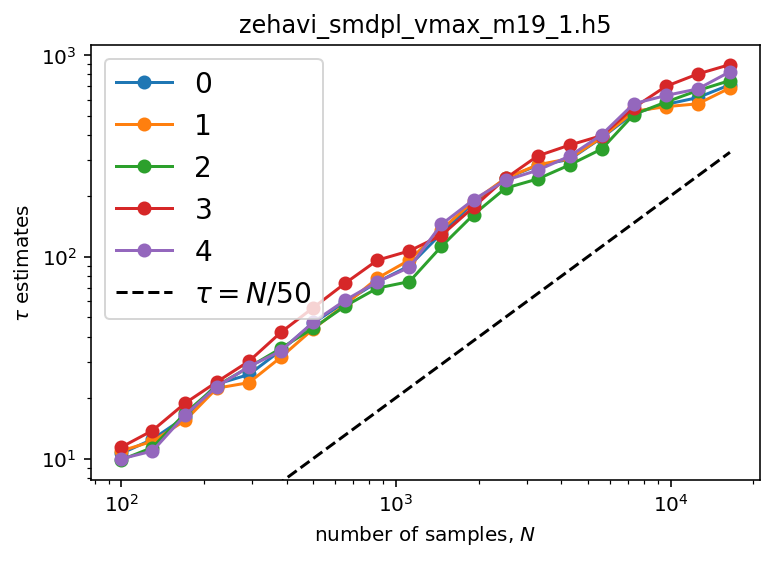

In [18]:
for j in range(5):
    chain = samples[:,:,j].T
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 20)).astype(int)
    gw2010 = np.empty(len(N))
    new = np.empty(len(N))
    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])

    # Plot the comparisons
    #plt.loglog(N, gw2010, "o-", label="G\&W 2010")
    plt.loglog(N, new, "o-", label=str(j))
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.title(fname)
plt.legend(fontsize=14);
#plt.savefig('autocorr_'+fname[:-3]+'.pdf')


In [20]:
print("Min chi2:",round(-2*log_prob_samples.max(),3))
print("Min chi2 params:",list(np.array(samples[log_prob_samples==log_prob_samples.max()]))[0])
min_chi2_loc = np.where((-2*log_prob_samples.max())==-2*log_prob_samples)
#print(wp_samples[min_chi2_loc][-1])
#print("Last Sample:",list(np.array(samples[-1,:,:])))

Min chi2: 9.738
Min chi2 params: [2.16000924 0.29929597 2.96122806 1.11038977 2.45234212]


In [21]:
#plot chi2 distribution
sort_chi2 = np.sort(-2*log_prob_samples,axis=None)
plt.hist(sort_chi2[0::50],bins=50,histtype='step')
mean = np.mean(sort_chi2[0::50])
plt.axvline(mean, label=str(round(mean,4)))
plt.legend()
plt.title('Chi2s ({})'.format(fname[:-3]))
#plt.savefig('chi2s_hist_'+fname[:-3]+'.pdf')

ValueError: supplied range of [inf, inf] is not finite

In [15]:
#calculate chi2 per degree of freedom
deg_of_frdm = 7
chi_per_deg = -2.0*log_prob_samples/deg_of_frdm
print("chi2 per dof:", chi_per_deg.min())
print('median,max,std: ',np.median(-2.0*log_prob_samples),np.max(-2.0*log_prob_samples),np.std(-2.0*log_prob_samples))
row,col = np.where(chi_per_deg<10.)
#randomly select 20 sets of parameters with chi2 per dof less than 6.5
choices = np.random.choice(samples[row,col].shape[0],20,replace=False)
param_string_sampling = samples[row,col][choices]
#print("Sets of parameters with chi2 per dof < 6.5")
param_sampling = []
for i in param_string_sampling:
    param_sampling.append(list(np.array(i)))
    #param_sampling.append(list(np.array(param_string_sampling)))
#print(-2.0*log_prob_samples[row,col][choices])

chi2 per dof: inf
median,max,std:  inf inf nan


ValueError: a must be greater than 0 unless no samples are taken

In [11]:
#Calculate median M1 HOD parameter with upper and lower limits at 16th and 84th percentiles
M0_vals = np.zeros(len(param_sampling))
M1_vals = np.zeros(len(param_sampling))
sigma_vals = np.zeros(len(param_sampling))
alpha_vals = np.zeros(len(param_sampling))
logMmin_vals = np.zeros(len(param_sampling))
for i in range(len(param_sampling)):
    logMmin_vals[i]+=param_sampling[i][0]
    alpha_vals[i]+=param_sampling[i][2]
    sigma_vals[i]+=param_sampling[i][1]
    M1_vals[i]+=param_sampling[i][4]
    M0_vals[i]+=param_sampling[i][3]
lo = np.median(M1_vals)-np.percentile(M1_vals,16)
hi = np.percentile(M1_vals,84)-np.median(M1_vals)
print(f"median M1 val: {round(np.median(M1_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(M0_vals)-np.percentile(M0_vals,16)
hi = np.percentile(M0_vals,84)-np.median(M0_vals)
print(f"median M0 val: {round(np.median(M0_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(logMmin_vals)-np.percentile(logMmin_vals,16)
hi = np.percentile(logMmin_vals,84)-np.median(logMmin_vals)
print(f"median logMmin val: {round(np.median(logMmin_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(alpha_vals)-np.percentile(alpha_vals,16)
hi = np.percentile(alpha_vals,84)-np.median(alpha_vals)
print(f"median alpha val: {round(np.median(alpha_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(sigma_vals)-np.percentile(sigma_vals,16)
hi = np.percentile(sigma_vals,84)-np.median(sigma_vals)
print(f"median sigma val: {round(np.median(sigma_vals),4)} (+{round(lo,4)},-{round(hi,4)})")

median M1 val: 13.2129 (+0.0405,-0.047)
median M0 val: 11.8191 (+1.4999,-0.3867)
median logMmin val: 12.003 (+0.1016,-0.1326)
median alpha val: 1.0254 (+0.0688,-0.0487)
median sigma val: 0.4493 (+0.2801,-0.2324)


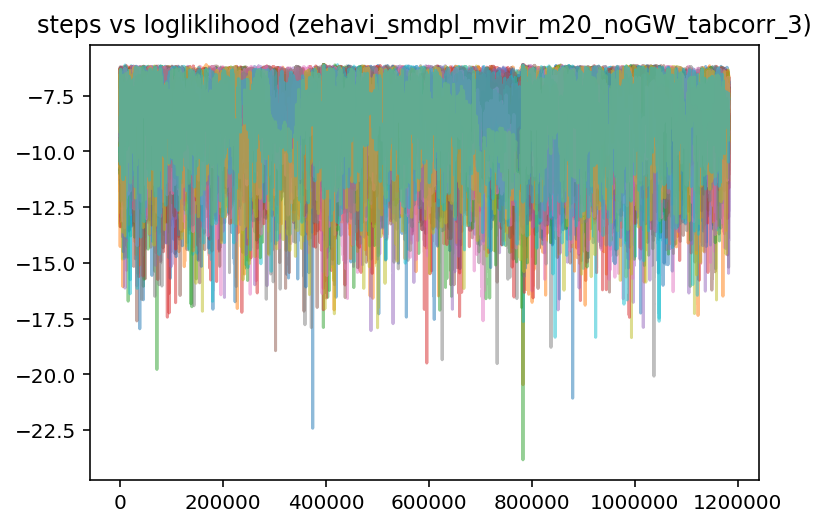

In [12]:
plt.plot(log_prob_samples[:,:],alpha=0.5)
#plt.ylim(-600,20)
plt.title("steps vs logliklihood ({})".format(fname[:-3]))
max_ll = log_prob_samples[:,:].max()
#plt.ylim(-20,0)
F"Max logliklihood: {max_ll}"
plt.savefig('steps_v_llike'+fname[:-3]+'.png')
plt.show()

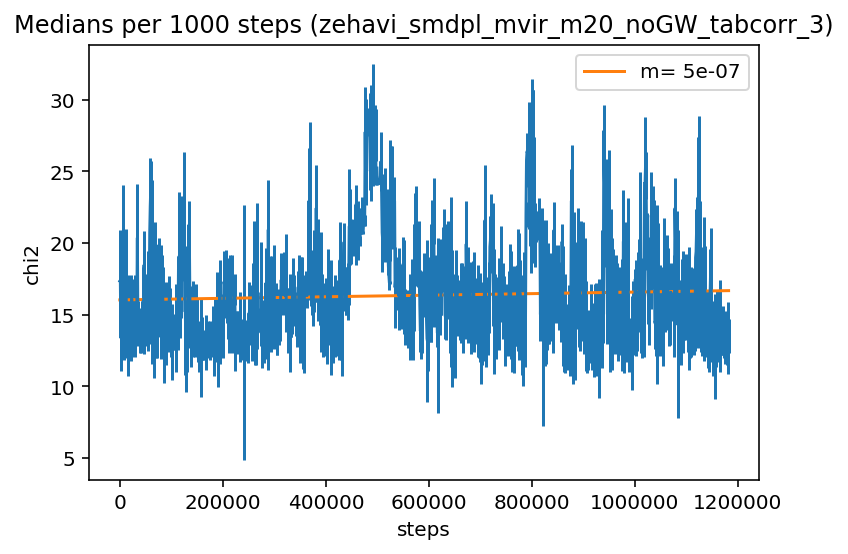

In [13]:
#For one chain, bin chi2s in bins of 1000 steps and take the median and std value per bin
intvl = 1000
chain_num = 1
n = int(len(log_prob_samples)/intvl)
steps = np.linspace(0,n*intvl,n)
meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(-2*log_prob_samples[i*intvl:(i+1)*intvl,chain_num])
    stds[i]+=np.std(-2*log_prob_samples[i*intvl:(i+1)*intvl,chain_num])

plt.errorbar(steps,meds,yerr=1.23*stds)
m,b = np.polyfit(steps,meds,deg=1)[0],np.polyfit(steps,meds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m= {}'.format(round(m,7)))
plt.ylabel('chi2')
plt.xlabel('steps')
plt.title('Medians per 1000 steps ({})'.format(fname[:-3]))
plt.legend()
plt.savefig('med_chi2_'+fname[:-3]+'.png')


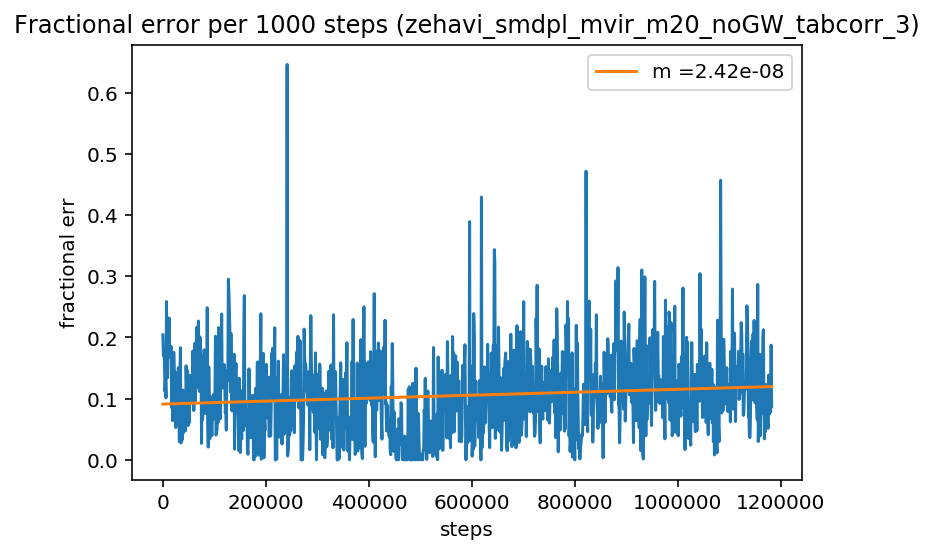

In [14]:
#fractional error of the same data as above
plt.plot(steps,1.23*stds/meds)
m,b = np.polyfit(steps,1.23*stds/meds,deg=1)[0],np.polyfit(steps,1.23*stds/meds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m ={}'.format(round(m,10)))
plt.ylabel('fractional err')
plt.xlabel('steps')
plt.title('Fractional error per 1000 steps ({})'.format(fname[:-3]))
plt.legend()
plt.savefig('med_chi2_err_'+fname[:-3]+'.png')

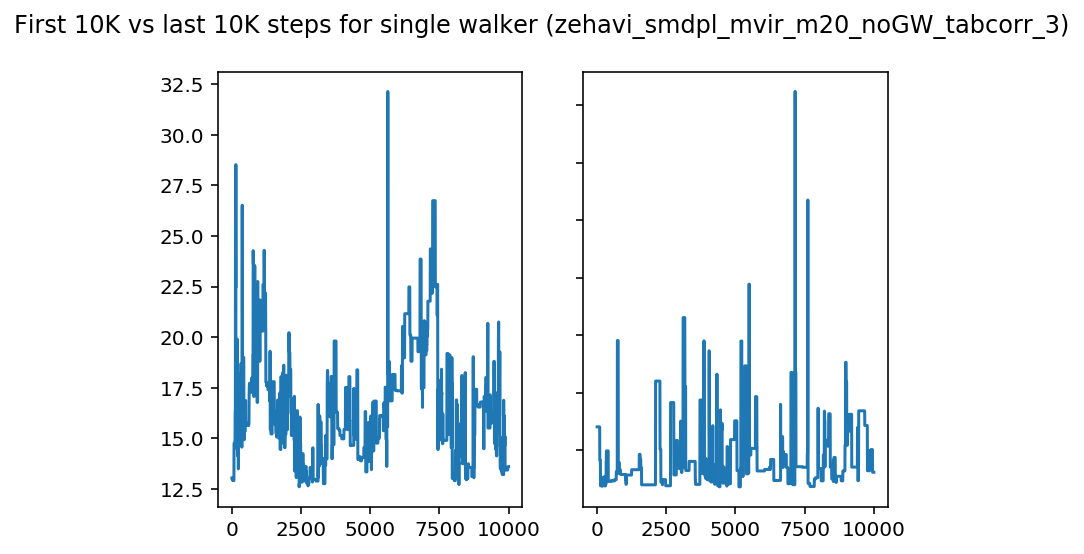

In [15]:
#plot first and last 10000 chi2 values for a single walker
steps = np.linspace(0,10_000,10_000)
chain_num = 1
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('First 10K vs last 10K steps for single walker ({})'.format(fname[:-3]))
ax1.plot(steps, -2*log_prob_samples[0:len(steps),chain_num])
ax2.plot(steps, -2*log_prob_samples[-len(steps):len(log_prob_samples),chain_num])
for ax in fig.get_axes():
    ax.label_outer()
plt.savefig('begin_end_chains_'+fname[:-3]+'.png')

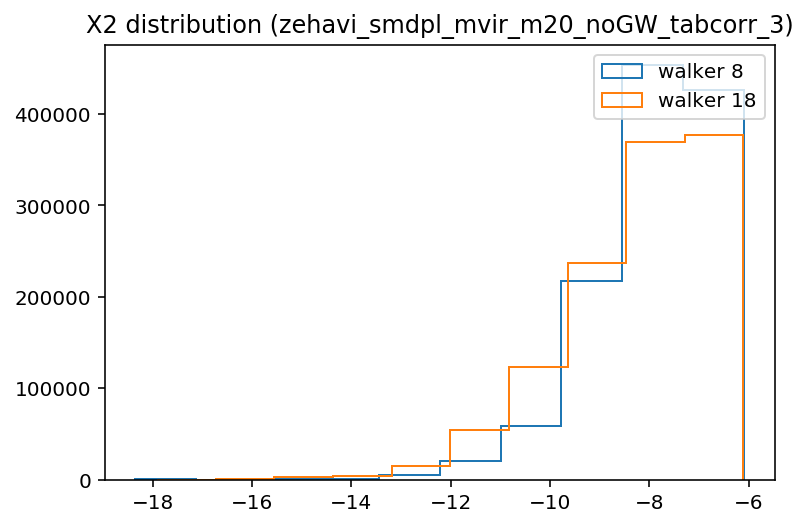

'Mean for walker 8: -14.96617143498359'

In [16]:
i = 8
def ind(i):
    if i < 35:
        j = i+10
    else: j = 35
    return j

counts,edges = np.histogram(log_prob_samples[row,col])
mean = np.mean(edges)
plt.hist(log_prob_samples[:,i],histtype='step',label='walker'+' ' + str(i))
plt.hist(log_prob_samples[:,ind(i)],histtype='step',label='walker'+' ' + str(ind(i)))
plt.legend()
#plt.xlim(-0.5e6,1e5)
plt.title("X2 distribution ({})".format(fname[:-3]))
plt.show()
F"Mean for walker {i}: {mean}"

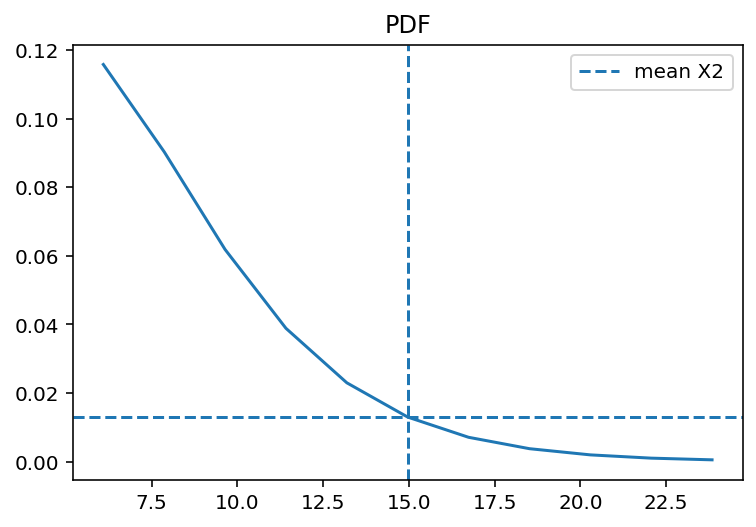

'PDF Mean: 0.01296381310317428'

In [17]:
pdf = chi2.pdf(-1*edges,deg_of_frdm)
plt.plot(-edges,pdf)
plt.axvline(-mean,linestyle='--',label='mean X2')
plt.axhline(chi2.pdf(-1*mean,deg_of_frdm),linestyle='--')
plt.title("PDF")
plt.legend()
plt.show()
F"PDF Mean: {chi2.pdf(-1*mean,deg_of_frdm)}"

In [18]:
mode = stats.mode(2*log_prob_samples[:])

cdf = chi2.cdf(-np.mean(mode[0]),deg_of_frdm)
print("pval =", 1-cdf)

cdf = chi2.cdf((-2*log_prob_samples[:].max()),deg_of_frdm)
print("pval chi2 min =", 1-cdf)

cdf = chi2.cdf(np.mean(-2*log_prob_samples[row,col]),deg_of_frdm)
print("pval =", 1-cdf)

pval = 0.02347240022891839
pval chi2 min = 0.09441394054935415
pval = 0.026322706649490768


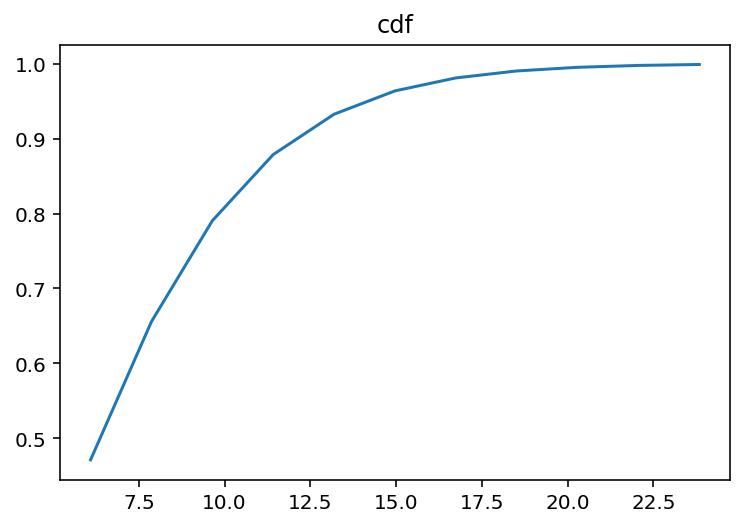

In [19]:
cdf = chi2.cdf(-1*edges,7)
plt.plot(-edges,cdf)
plt.title("cdf")
plt.show()

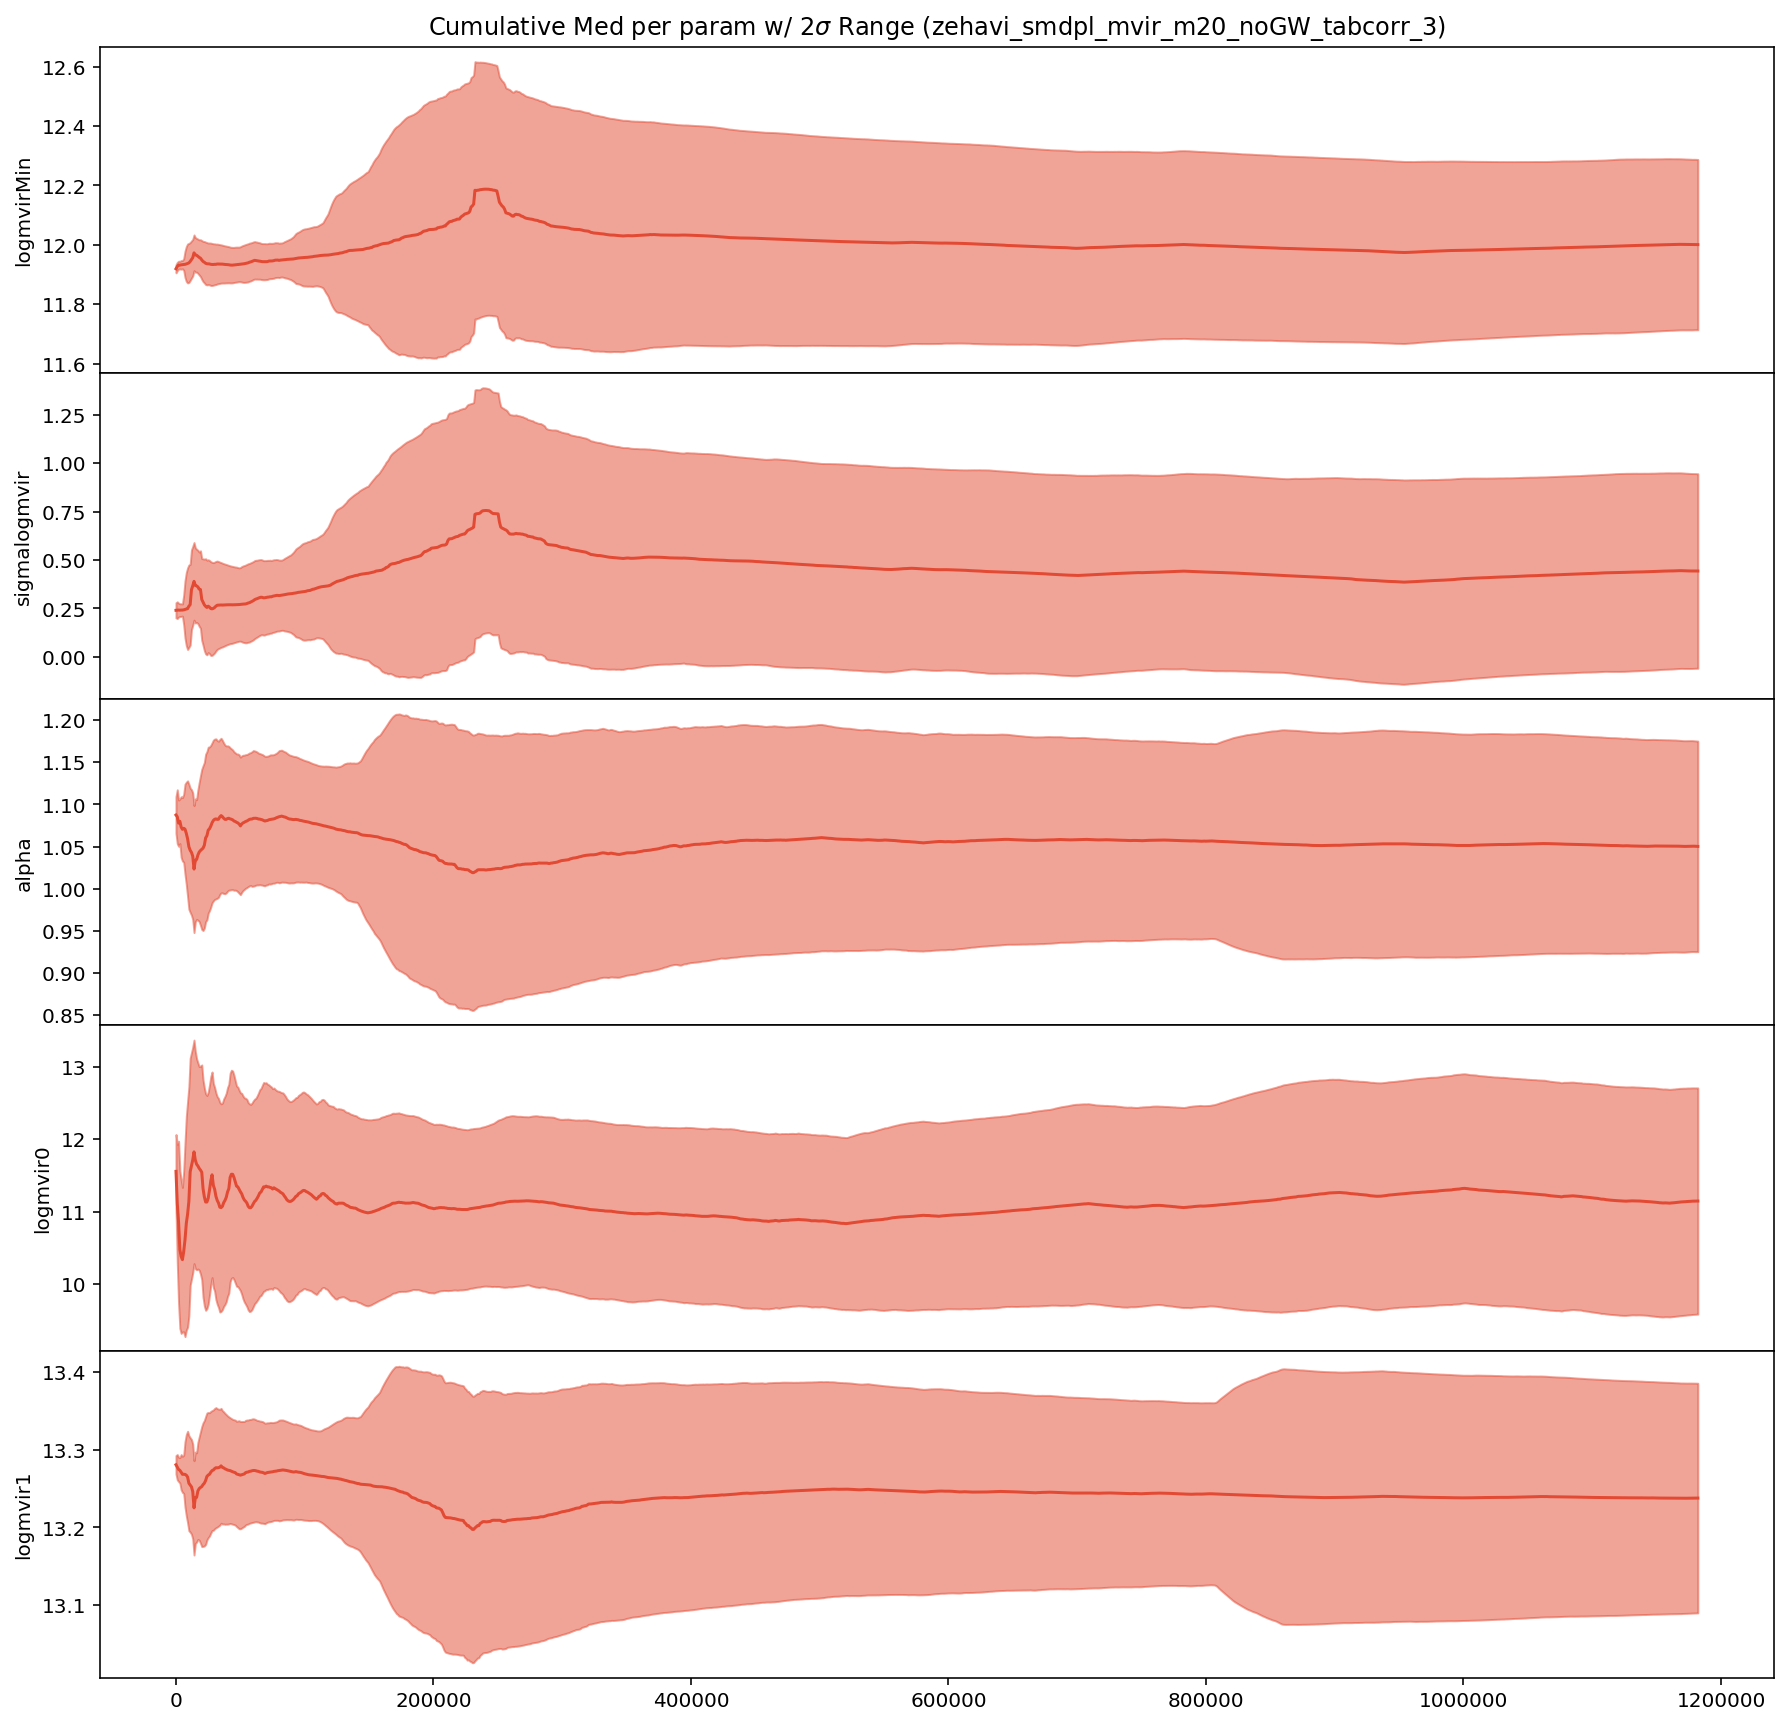

In [20]:
j = 4 #walker number
c = ['#e34a33']#['#fee8c8','#fdbb84','#e34a33']
intvl = 1000 #steps to take median over
n = int(len(samples)/intvl)
steps = np.linspace(0,n*intvl,n)

fig, axs = plt.subplots(5,figsize=(15,15),gridspec_kw={'hspace': 0},sharex=True)
meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,0])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,0],ddof=1)
axs[0].plot(steps,meds,c= c[0])
axs[0].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[0].set(ylabel='log{}Min'.format(param))
axs[0].set(title='Cumulative Med per param w/ 2$\sigma$ Range ({})'.format(fname[:-3]))

meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,1])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,1],ddof=1)
axs[1].plot(steps,meds,c= c[0])
axs[1].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[1].set(ylabel='sigmalog{}'.format(param))


meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,2])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,2],ddof=1)
axs[2].plot(steps,meds,c= c[0])
axs[2].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[2].set(ylabel='alpha')


meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,3])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,3],ddof=1)
axs[3].plot(steps,meds,c= c[0])
axs[3].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[3].set(ylabel='log{}0'.format(param))

meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,4])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,4],ddof=1)
axs[4].plot(steps,meds,c= c[0])
axs[4].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[4].set(ylabel='log{}1'.format(param))


plt.savefig('param_v_step_'+fname[:-3]+'.pdf')

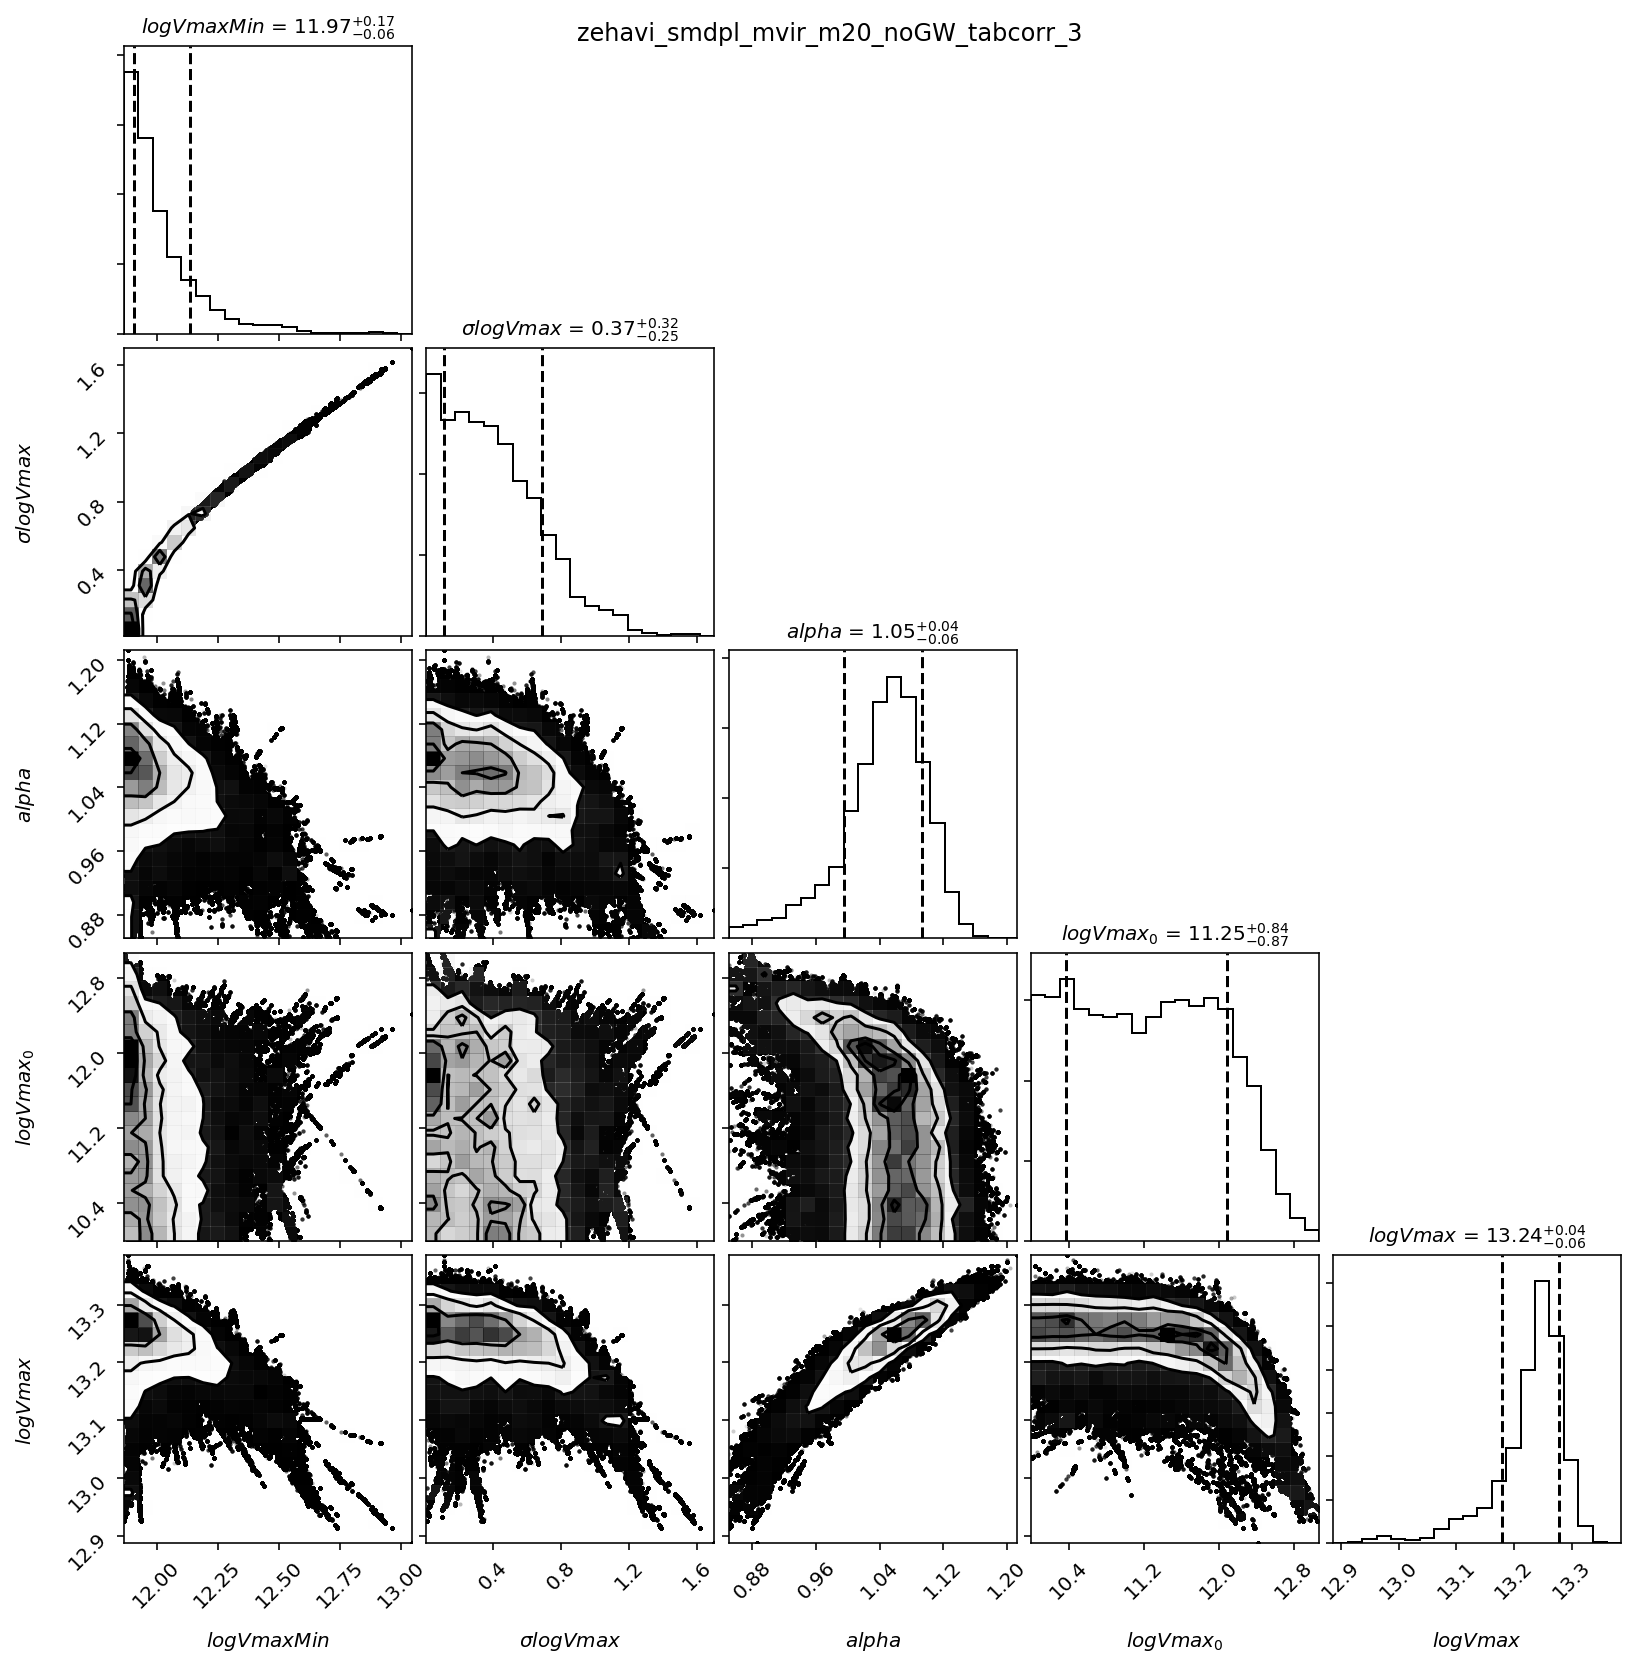

In [21]:
ndim=5
fig = corner.corner(samples.reshape((-1,ndim)),
        labels=["$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},quantiles=(0.16, 0.84))#, levels=(1-np.exp(-0.5),))
fig.suptitle('{}'.format(fname[:-3]))
plt.savefig('corner_'+fname[:-3]+'.png')

# 6 Param Stats

In [66]:
#fname = "combo_param_allparam_fit_a97_100_m21.h5"
#fname = "combo_param_allparam_fit_a03_33_m21.h5"
#fname = "combo_param_allparam_fit_a33_66_m21.h5"
#fname = "combo_param_allparam_fit_a0_m21.h5"
fname = "mass_concentration_fit_m20_new_mod.h5"
print('{}'.format(fname,fname))
param = 'pseudo'

mass_concentration_fit_m20_new_mod.h5


In [67]:
files = [fname]

#files = [fname4,fname5]
s = []
log_prob_s = []
wp = []

for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=0, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=0, flat=False, thin=1))
    wp.append(reader.get_blobs(discard=0))
    
print(np.shape(wp))
print(np.shape(s))
print(np.shape(log_prob_s))

(1,)
(1, 44264, 35, 6)
(1, 44264, 35)


In [68]:
max_n = reader.iteration
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

tau = reader.get_autocorr_time(tol=0)
autocorr[index] = np.mean(tau)
index += 1

# Check convergence
converged = (tau * 100 < reader.iteration)
converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
old_tau = tau
print(converged,tau)

[False False False False False False] [ 719.90642047 1477.1995177  1434.1555648   606.64206646  998.97373788
  595.95088147]


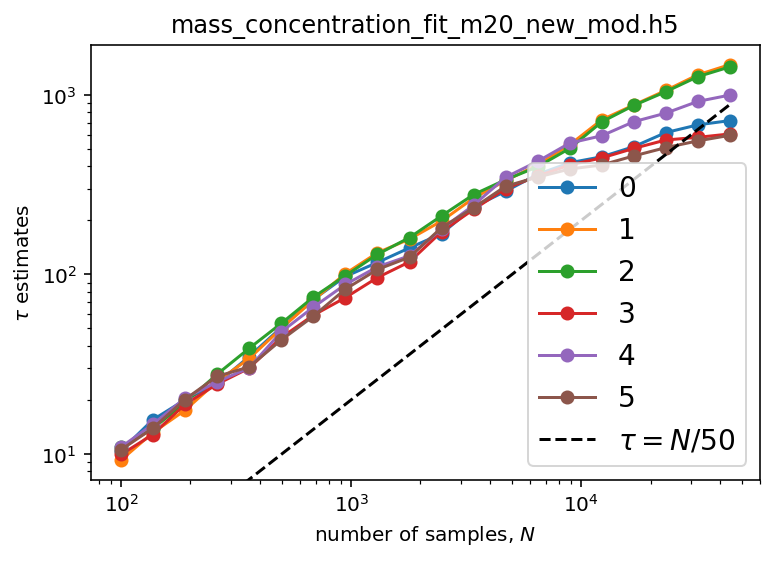

In [69]:
for j in range(6):
    chain = reader.get_chain()[:,:,j].T
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 20)).astype(int)
    #gw2010 = np.empty(len(N))
    new = np.empty(len(N))
    for i, n in enumerate(N):
        #gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])

    # Plot the comparisons
    #plt.loglog(N, gw2010, "o-", label="G\&W 2010")
    plt.loglog(N, new, "o-", label=str(j))
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.title(str(fname))
plt.legend(fontsize=14);
#plt.savefig("autocorr_"+fname[:-3]+".png")

In [60]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wp[i+1]))
else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]

In [61]:
print("Min chi2/dof:",round(-2*log_prob_samples.max(),3)/6)
print("Min chi2 params:",list(np.array(samples[np.where(log_prob_samples==log_prob_samples.max())]))[0])
min_chi2_loc = np.where((-2*log_prob_samples.max())==-2*log_prob_samples)
#print(wp_samples[min_chi2_loc][-1])

Min chi2/dof: 0.37083333333333335
Min chi2 params: [ 0.04622613 12.69531398  0.29446393  1.01371999 13.10527336 13.88284891]


In [35]:
#calculate chi2 per degree of freedom
deg_of_frdm = 6
chi_per_deg = -2.0*log_prob_samples/deg_of_frdm
print("chi2 per dof:", chi_per_deg.min())
print('median,max,std: ',np.median(-2.0*log_prob_samples),np.max(-2.0*log_prob_samples),np.std(-2.0*log_prob_samples))
row,col = np.where(chi_per_deg<750000.)
#randomly select 20 sets of parameters with chi2 per dof less than 6.5
choices = np.random.choice(samples[row,col].shape[0],10,replace=False)
param_string_sampling = samples[row,col][choices]
#print("Sets of parameters with chi2 per dof < 6.5")
param_sampling = []
for i in param_string_sampling:
    param_sampling.append(list(np.array(i)))
    #param_sampling.append(list(np.array(param_string_sampling)))
#print(-2.0*log_prob_samples[row,col][choices])

chi2 per dof: 3.387453372664391
median,max,std:  29.973106312059556 56.933738776030225 4.210370671202508


In [114]:
#Calculate median M1 HOD parameter with upper and lower limits at 16th and 84th percentiles
a_vals = np.zeros(len(param_sampling))
for i in range(len(param_sampling)):
    a_vals[i]+=param_sampling[i][0]
lo = np.median(a_vals)-np.percentile(a_vals,16)
hi = np.percentile(a_vals,84)-np.median(a_vals)
print(f"median a val: {round(np.median(a_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
M0_vals = np.zeros(len(param_sampling))
M1_vals = np.zeros(len(param_sampling))
sigma_vals = np.zeros(len(param_sampling))
alpha_vals = np.zeros(len(param_sampling))
logMmin_vals = np.zeros(len(param_sampling))
for i in range(len(param_sampling)):
    logMmin_vals[i]+=param_sampling[i][1]
    alpha_vals[i]+=param_sampling[i][2]
    sigma_vals[i]+=param_sampling[i][3]
    M0_vals[i]+=param_sampling[i][4]
    M1_vals[i]+=param_sampling[i][5]
lo = np.median(logMmin_vals)-np.percentile(logMmin_vals,16)
hi = np.percentile(logMmin_vals,84)-np.median(logMmin_vals)
print(f"median logMmin val: {round(np.median(logMmin_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(alpha_vals)-np.percentile(alpha_vals,16)
hi = np.percentile(alpha_vals,84)-np.median(alpha_vals)
print(f"median alpha val: {round(np.median(alpha_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(sigma_vals)-np.percentile(sigma_vals,16)
hi = np.percentile(sigma_vals,84)-np.median(sigma_vals)
print(f"median sigma val: {round(np.median(sigma_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(M0_vals)-np.percentile(M0_vals,16)
hi = np.percentile(M0_vals,84)-np.median(M0_vals)
print(f"median M0 val: {round(np.median(M0_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(M1_vals)-np.percentile(M1_vals,16)
hi = np.percentile(M1_vals,84)-np.median(M1_vals)
print(f"median M1 val: {round(np.median(M1_vals),4)} (+{round(lo,4)},-{round(hi,4)})")

median a val: 0.1531 (+0.053,-0.0303)
median logMmin val: 12.6873 (+0.0127,-0.0104)
median alpha val: 0.1567 (+0.1181,-0.0862)
median sigma val: 1.008 (+0.0753,-0.1724)
median M0 val: 13.1573 (+0.5394,-0.2446)
median M1 val: 13.9125 (+0.0524,-0.1105)


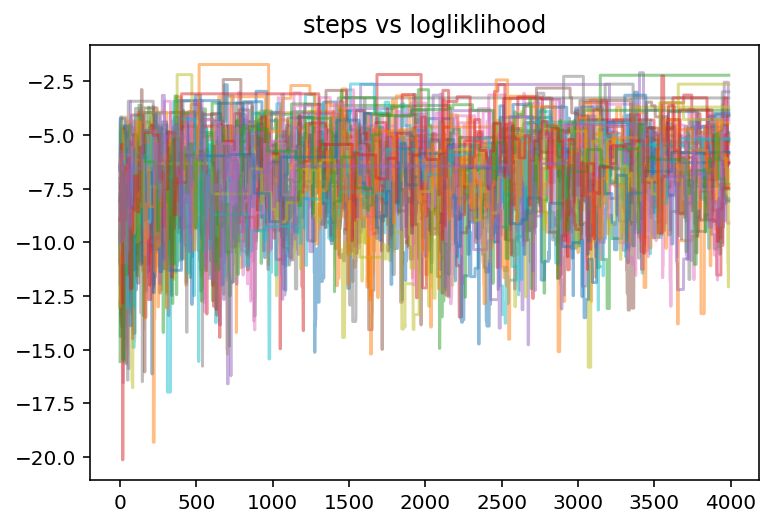

'Max logliklihood: -1.720595702101012'

In [115]:
plt.plot(log_prob_samples[:,:],alpha=0.5)
#plt.ylim(-600,20)
plt.title("steps vs logliklihood")
max_ll = log_prob_samples[:,:].max()
plt.show()
F"Max logliklihood: {max_ll}"

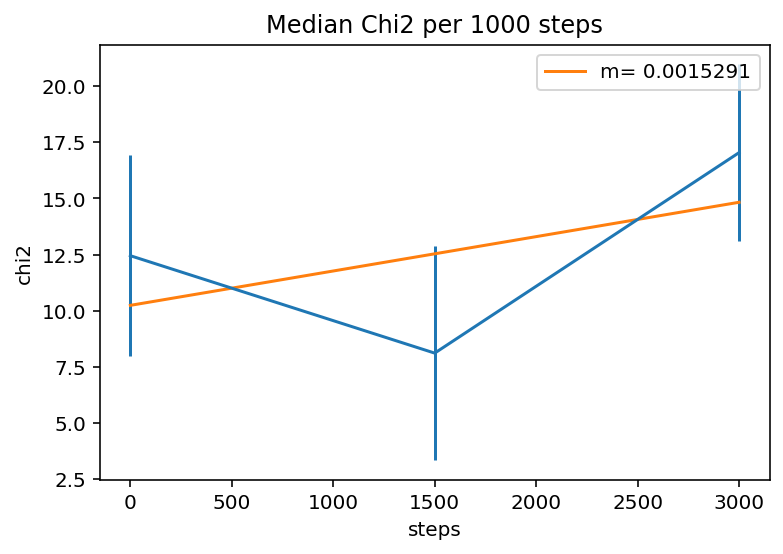

In [116]:
intvl = 1000
chain_num = 1
n = int(len(log_prob_samples)/intvl)
steps = np.linspace(0,n*intvl,n)
ameds = np.zeros(n)
astds = np.zeros(n)
meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(-2*log_prob_samples[i*intvl:(i+1)*intvl,chain_num])
    stds[i]+=np.std(-2*log_prob_samples[i*intvl:(i+1)*intvl,chain_num])
    ameds[i]+=np.median(samples[i*intvl:(i+1)*intvl,chain_num,0])
    astds[i]+=np.std(samples[i*intvl:(i+1)*intvl,chain_num,0])
plt.errorbar(steps,meds,yerr=1.23*stds)
m,b = np.polyfit(steps,meds,deg=1)[0],np.polyfit(steps,meds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m= {}'.format(round(m,7)))
plt.ylabel('chi2')
plt.xlabel('steps')
plt.title('Median Chi2 per {} steps'.format(intvl))
plt.legend()
#plt.savefig("med_chi2_err"+fname[:-3]+".png")


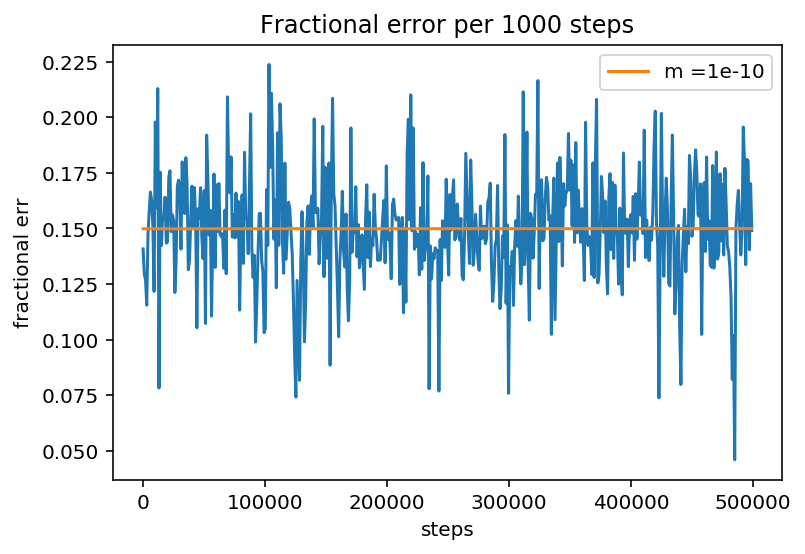

In [13]:
plt.plot(steps,1.23*stds/meds)
m,b = np.polyfit(steps,1.23*stds/meds,deg=1)[0],np.polyfit(steps,1.23*stds/meds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m ={}'.format(round(m,10)))
plt.ylabel('fractional err')
plt.xlabel('steps')
plt.title('Fractional error per {} steps'.format(intvl))
plt.legend()
#plt.savefig("med_chi2_err"+fname[:-3]+".png")


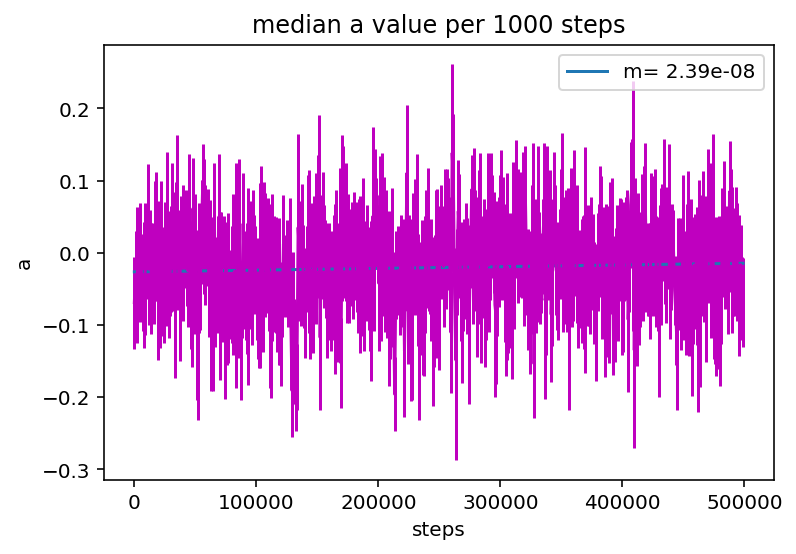

In [14]:
plt.errorbar(steps,ameds,yerr=1.23*astds,c='m')
m,b = np.polyfit(steps,ameds,deg=1)[0],np.polyfit(steps,ameds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m= {}'.format(round(m,10)))
plt.ylabel('a')
plt.xlabel('steps')
plt.title('median a value per {} steps'.format(intvl))
plt.legend()
#plt.savefig("med_a_"+fname[:-3]+".png")


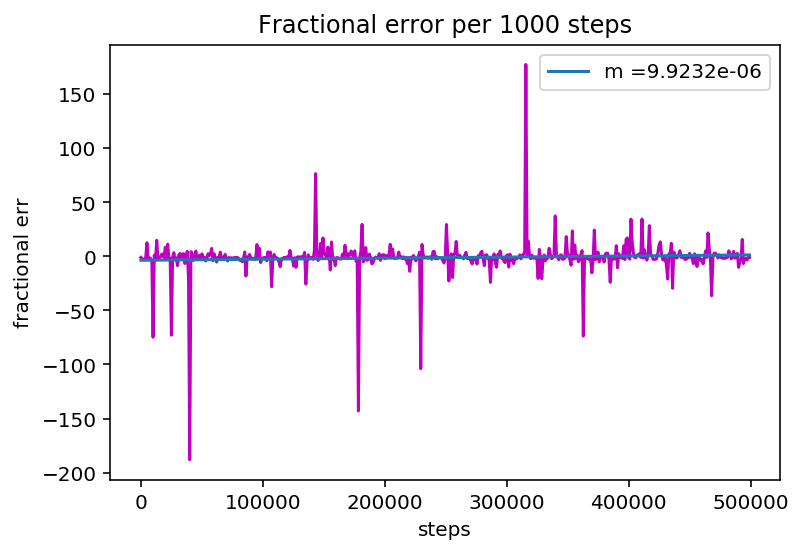

In [15]:
plt.plot(steps,1.23*astds/ameds,c='m')
m,b = np.polyfit(steps,1.23*astds/ameds,deg=1)[0],np.polyfit(steps,1.23*astds/ameds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m ={}'.format(round(m,10)))
plt.ylabel('fractional err')
plt.xlabel('steps')
plt.title('Fractional error per {} steps'.format(intvl))
plt.legend()
#plt.savefig("med_a_err_"+fname[:-3]+".png")

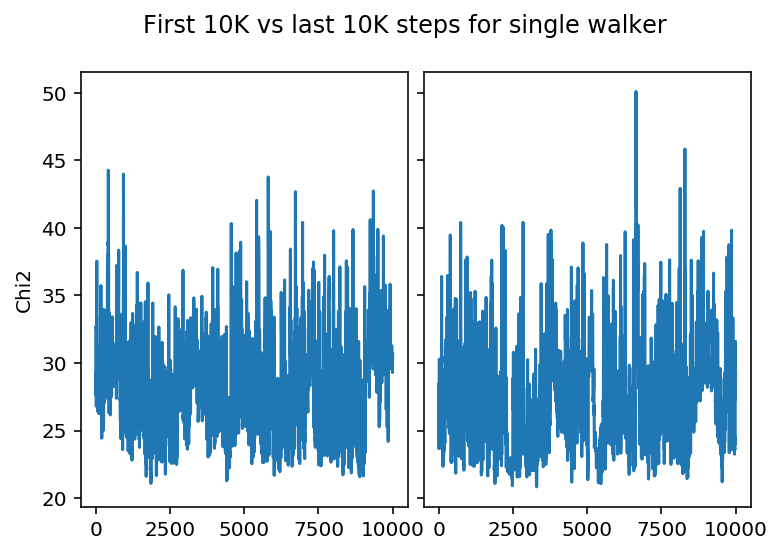

In [16]:
#plot first and last 10000 chi2 values for a single walker
steps = np.linspace(0,10_000,10_000)
chain_num = 1
fig, (ax1, ax2) = plt.subplots(1, 2,sharey = True,gridspec_kw={'wspace': 0.05})
fig.suptitle('First 10K vs last 10K steps for single walker')
ax1.plot(steps, -2*log_prob_samples[0:len(steps),chain_num])
ax1.set(ylabel='Chi2')
ax2.plot(steps, -2*log_prob_samples[-len(steps):len(log_prob_samples),chain_num])
for ax in fig.get_axes():
    ax.label_outer()
#plt.savefig('comp_begin_end_chains_'+fname[:-3]+'.png')

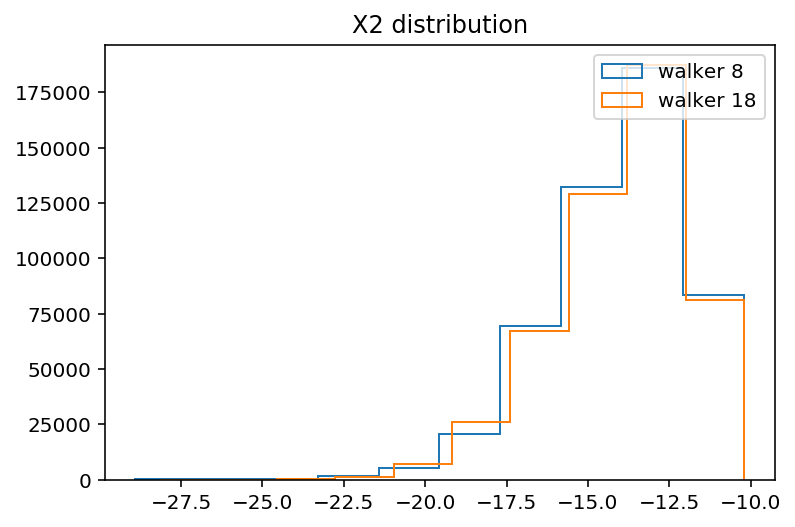

'Mean for walker 8: -20.570331628475177'

In [17]:
i = 8
def ind(i):
    if i < 35:
        j = i+10
    else: j = 35
    return j

counts,edges = np.histogram(log_prob_samples[row,col])
mean = np.mean(edges)
plt.hist(log_prob_samples[:,i],histtype='step',label='walker'+' ' + str(i))
plt.hist(log_prob_samples[:,ind(i)],histtype='step',label='walker'+' ' + str(ind(i)))
plt.legend()
#plt.xlim(-0.5e6,1e5)
plt.title("X2 distribution")
plt.show()
F"Mean for walker {i}: {mean}"

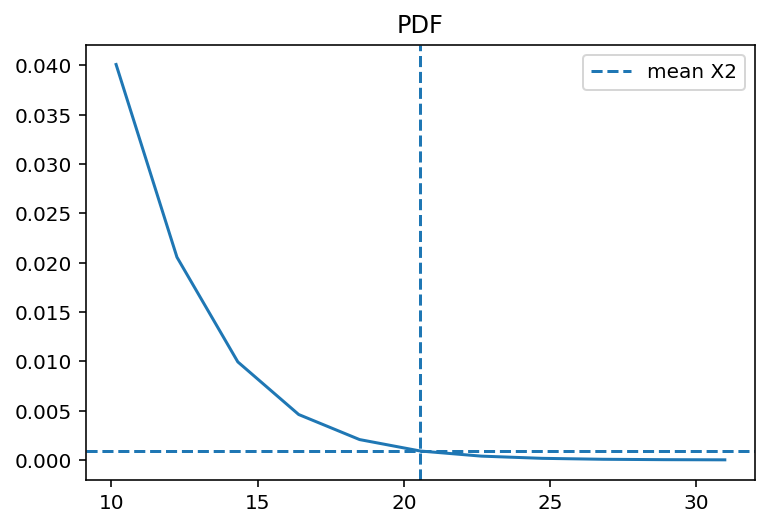

'PDF Mean: 0.000902759038645123'

In [18]:
pdf = chi2.pdf(-1*edges,deg_of_frdm)
plt.plot(-edges,pdf)
plt.axvline(-mean,linestyle='--',label='mean X2')
plt.axhline(chi2.pdf(-1*mean,deg_of_frdm),linestyle='--')
plt.title("PDF")
plt.legend()
plt.show()
F"PDF Mean: {chi2.pdf(-1*mean,deg_of_frdm)}"

In [19]:
mode = stats.mode(2*log_prob_samples[:])

cdf = chi2.cdf(-np.mean(mode[0]),deg_of_frdm)
print("pval =", 1-cdf)

cdf = chi2.cdf((-2*log_prob_samples[:].max()),deg_of_frdm)
print("pval chi2 min =", 1-cdf)

cdf = chi2.cdf(np.mean(-2*log_prob_samples[row,col]),deg_of_frdm)
print("pval =", 1-cdf)

pval = 6.33582325723081e-05
pval chi2 min = 0.002420742843857848
pval = 9.706014061816592e-05


Text(0.5, 1.0, 'Chi2s')

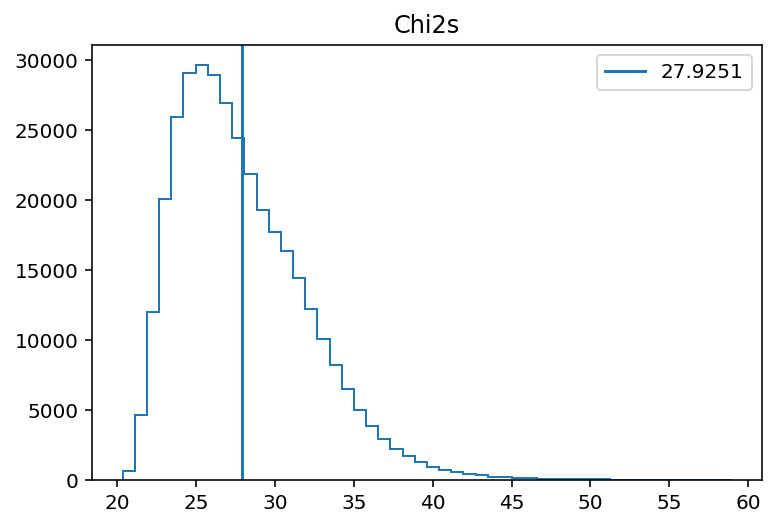

In [20]:
#plot chi2 distribution
sort_chi2 = np.sort(-2*log_prob_samples,axis=None)
plt.hist(sort_chi2[0::50],bins=50,histtype='step')
mean = np.mean(sort_chi2[0::50])
plt.axvline(mean, label=str(round(mean,4)))
plt.legend()
plt.title('Chi2s')
#plt.savefig('chi2s_hist_'+fname[:-3]+'.png')

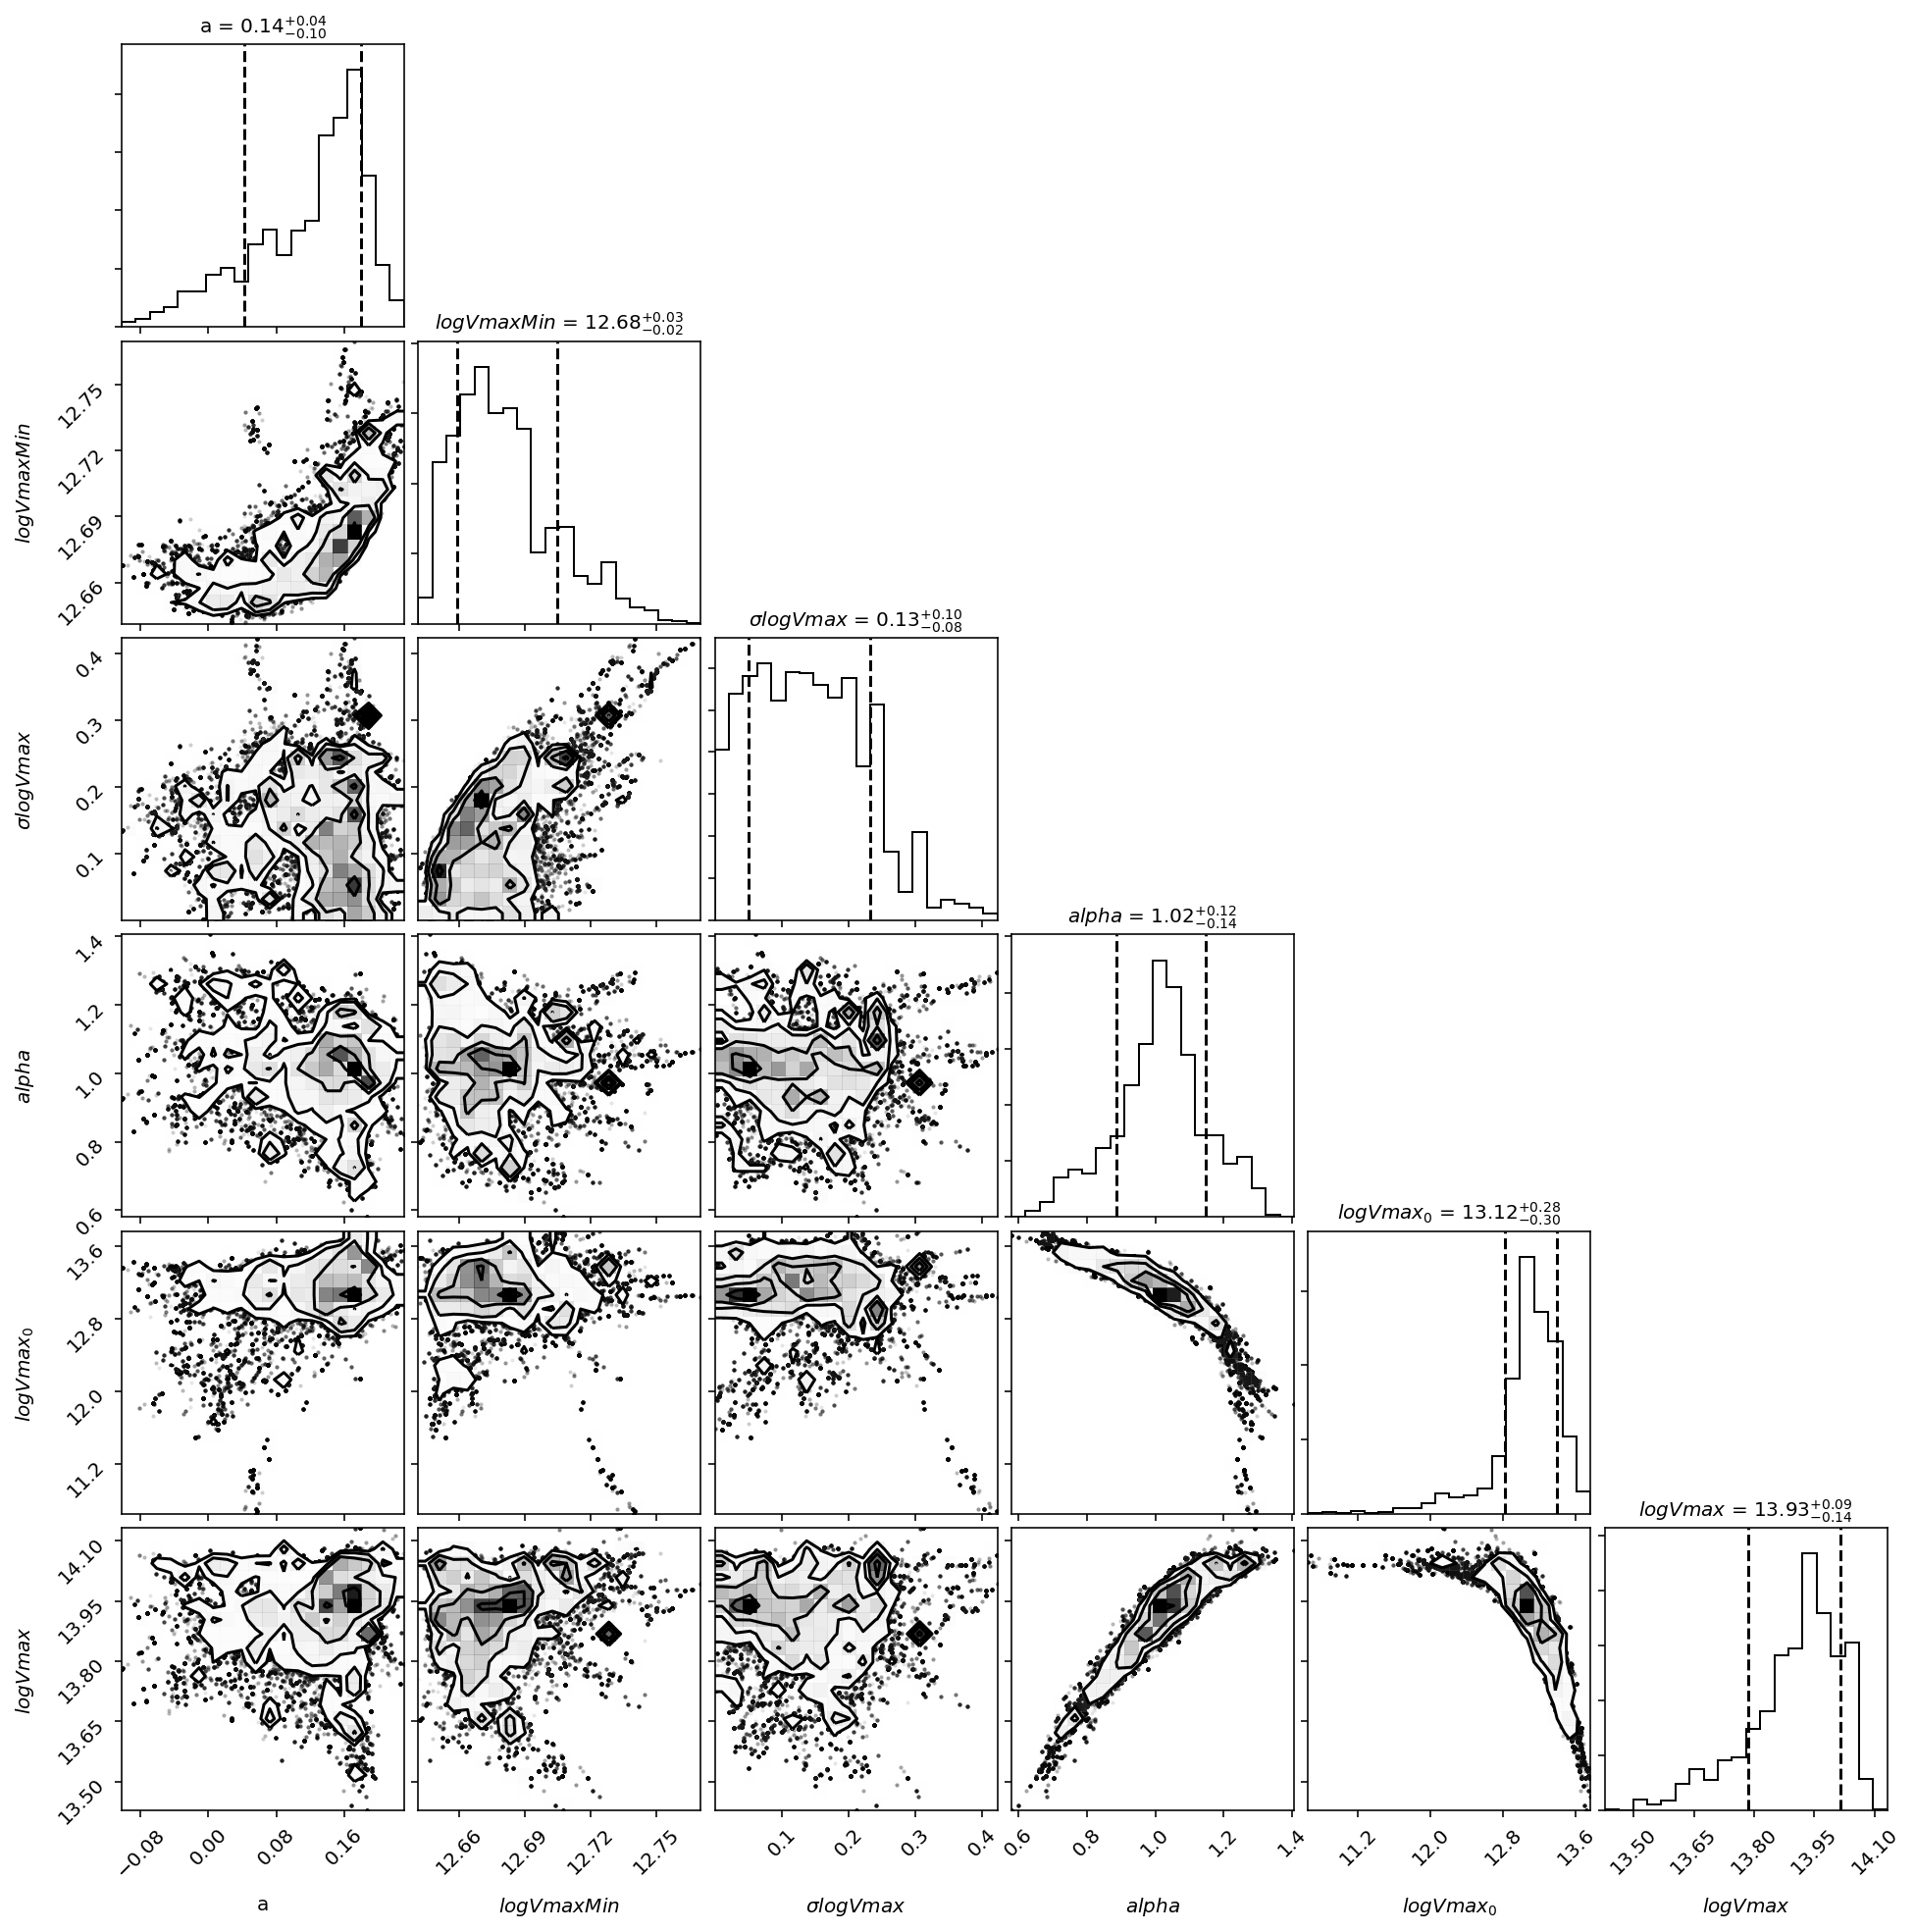

In [117]:
ndim=6
fig = corner.corner(samples.reshape((-1,ndim)),
        labels=["a","$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},quantiles=(0.16, 0.84))#, levels=(1-np.exp(-0.5),))
#plt.savefig('corner_'+fname[:-3]+'.png')

[Text(0, 0.5, 'logpseudo1')]

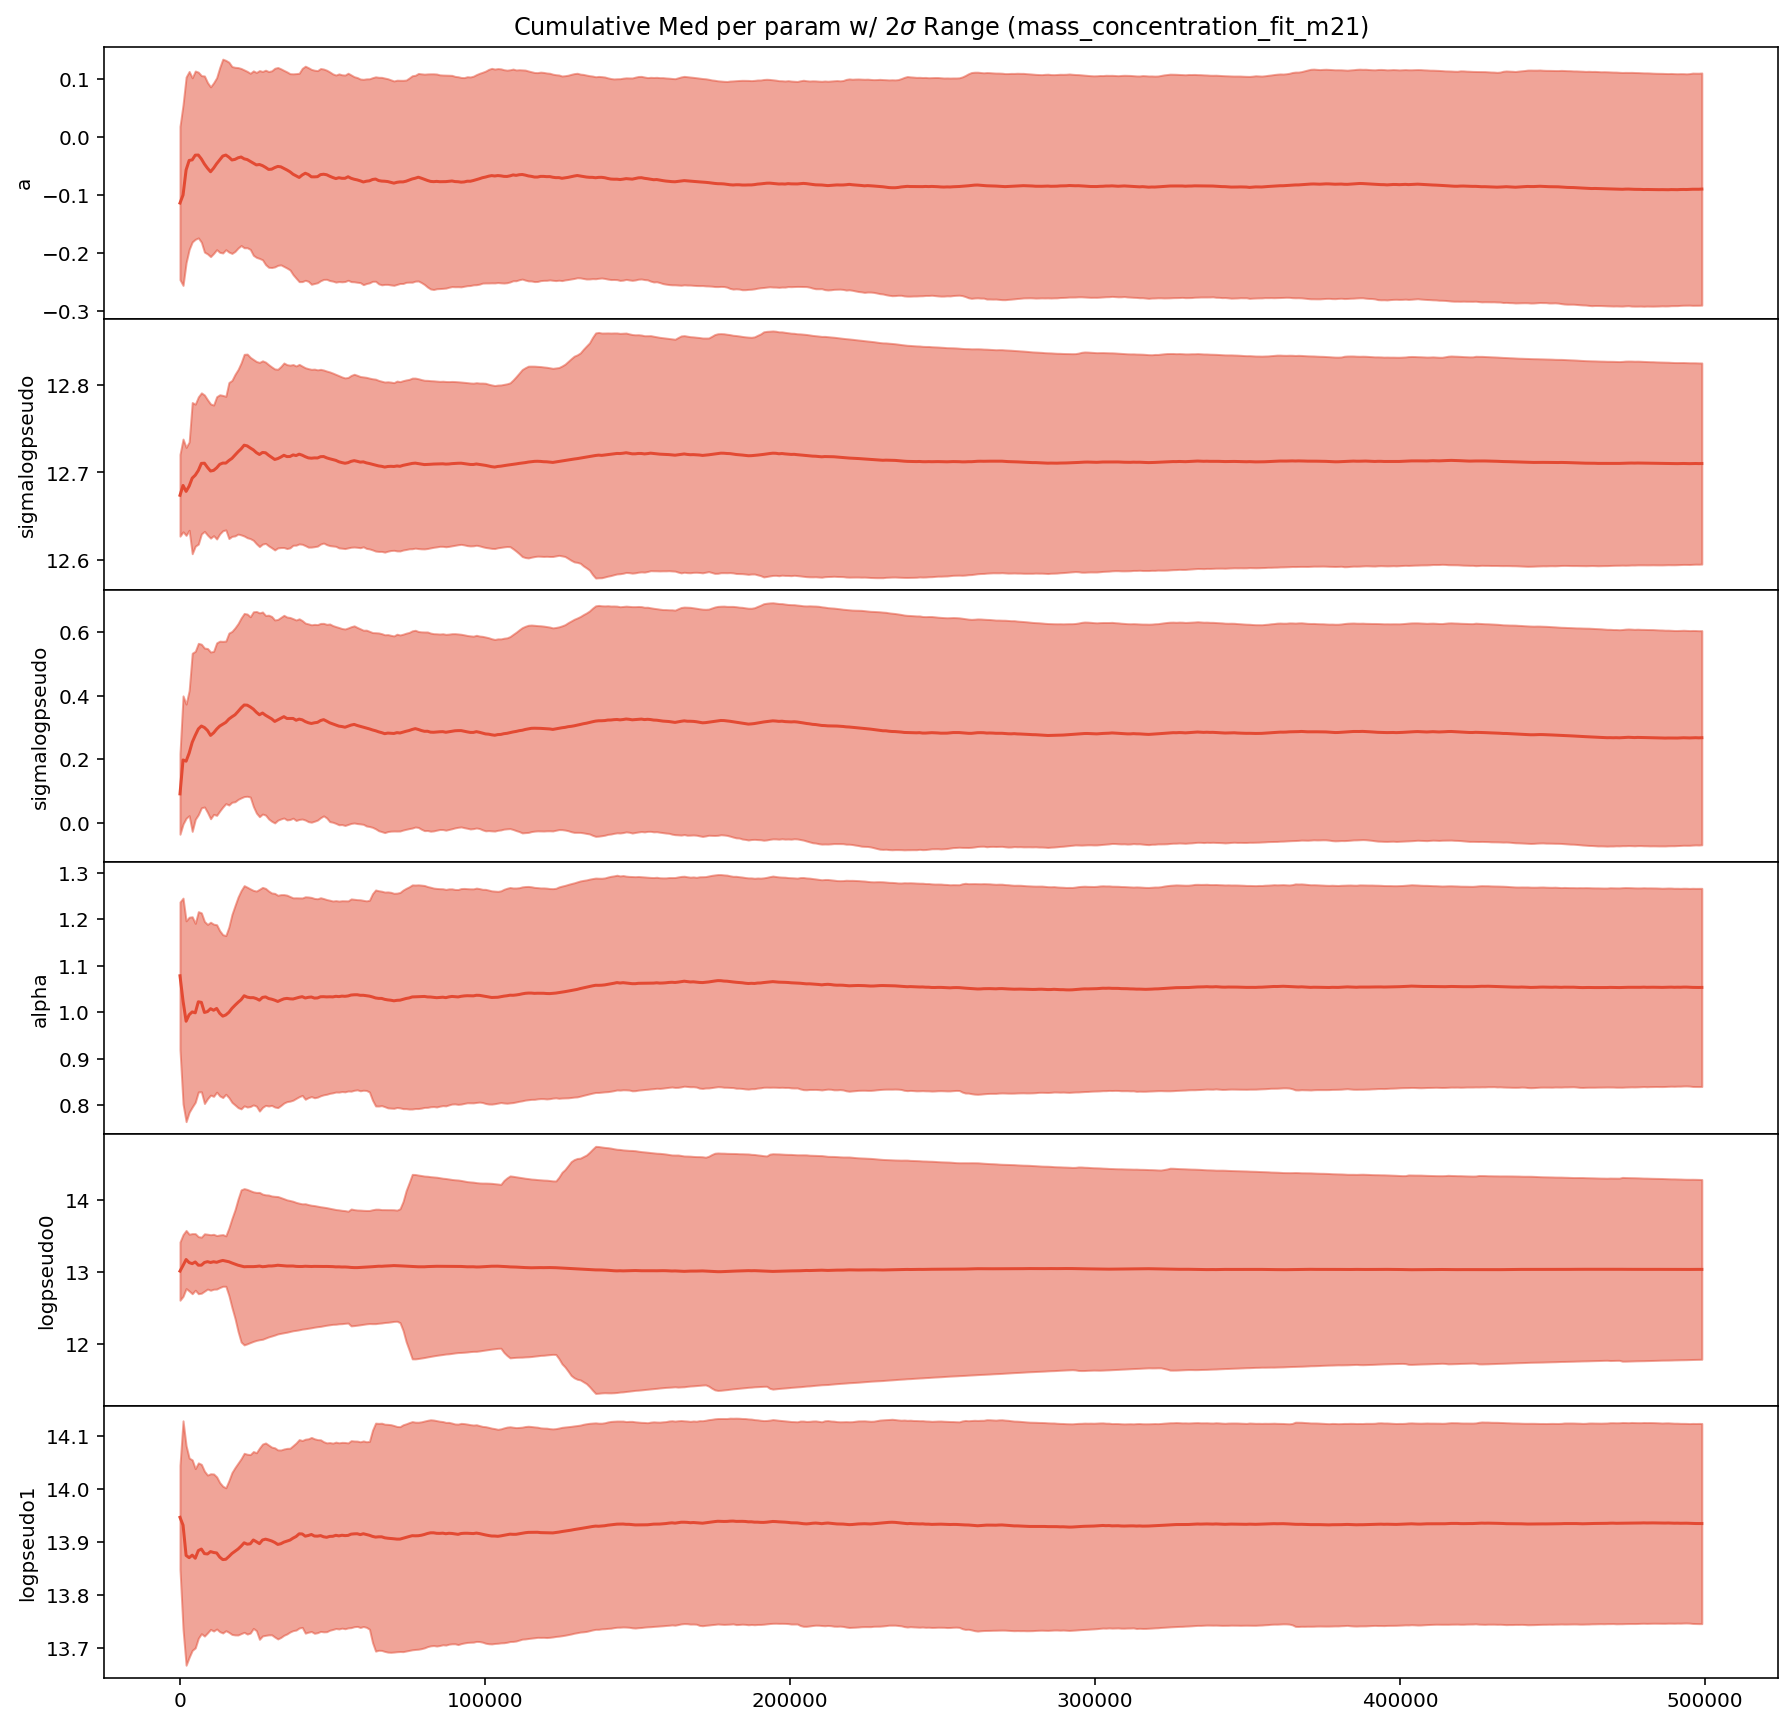

In [64]:
j = 4 #walker number
c = ['#e34a33']#['#fee8c8','#fdbb84','#e34a33']
intvl = 1000 #steps to take median over
n = int(len(samples)/intvl)
steps = np.linspace(0,n*intvl,n)

fig, axs = plt.subplots(6,figsize=(15,15),gridspec_kw={'hspace': 0},sharex=True)
meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,0])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,0],ddof=1)
axs[0].plot(steps,meds,c= c[0])
axs[0].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[0].set(ylabel='a')
axs[0].set(title='Cumulative Med per param w/ 2$\sigma$ Range ({})'.format(fname[:-3]))

meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,1])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,1],ddof=1)
axs[1].plot(steps,meds,c= c[0])
axs[1].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[1].set(ylabel='sigmalog{}'.format(param))


meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,2])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,2],ddof=1)
axs[2].plot(steps,meds,c= c[0])
axs[2].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[2].set(ylabel='sigmalog{}'.format(param))


meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,3])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,3],ddof=1)
axs[3].plot(steps,meds,c= c[0])
axs[3].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[3].set(ylabel='alpha')

meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,4])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,4],ddof=1)
axs[4].plot(steps,meds,c= c[0])
axs[4].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[4].set(ylabel='log{}0'.format(param))

meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,5])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,5],ddof=1)
axs[5].plot(steps,meds,c= c[0])
axs[5].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[5].set(ylabel='log{}1'.format(param))

#plt.savefig('param_v_step_'+fname[:-3]+'.png')

In [190]:
a_vals = samples.reshape(74000*35,6)[:,0]
cut1 = np.where(0.66<=a_vals)
cut2 = np.where(0.97>a_vals[cut1])

ValueError: cannot reshape array of size 10290000 into shape (2590000,6)

In [ ]:
chi2 = -2*log_prob_samples.reshape(74000*35)[cut1][cut2]

In [ ]:
plt.scatter(a_vals[cut1][cut2][::intvl],chi2[::intvl])

In [ ]:
plt.hist(a_vals[cut1][cut2],histtype='step')
plt.hist(chi2,histtype='step')

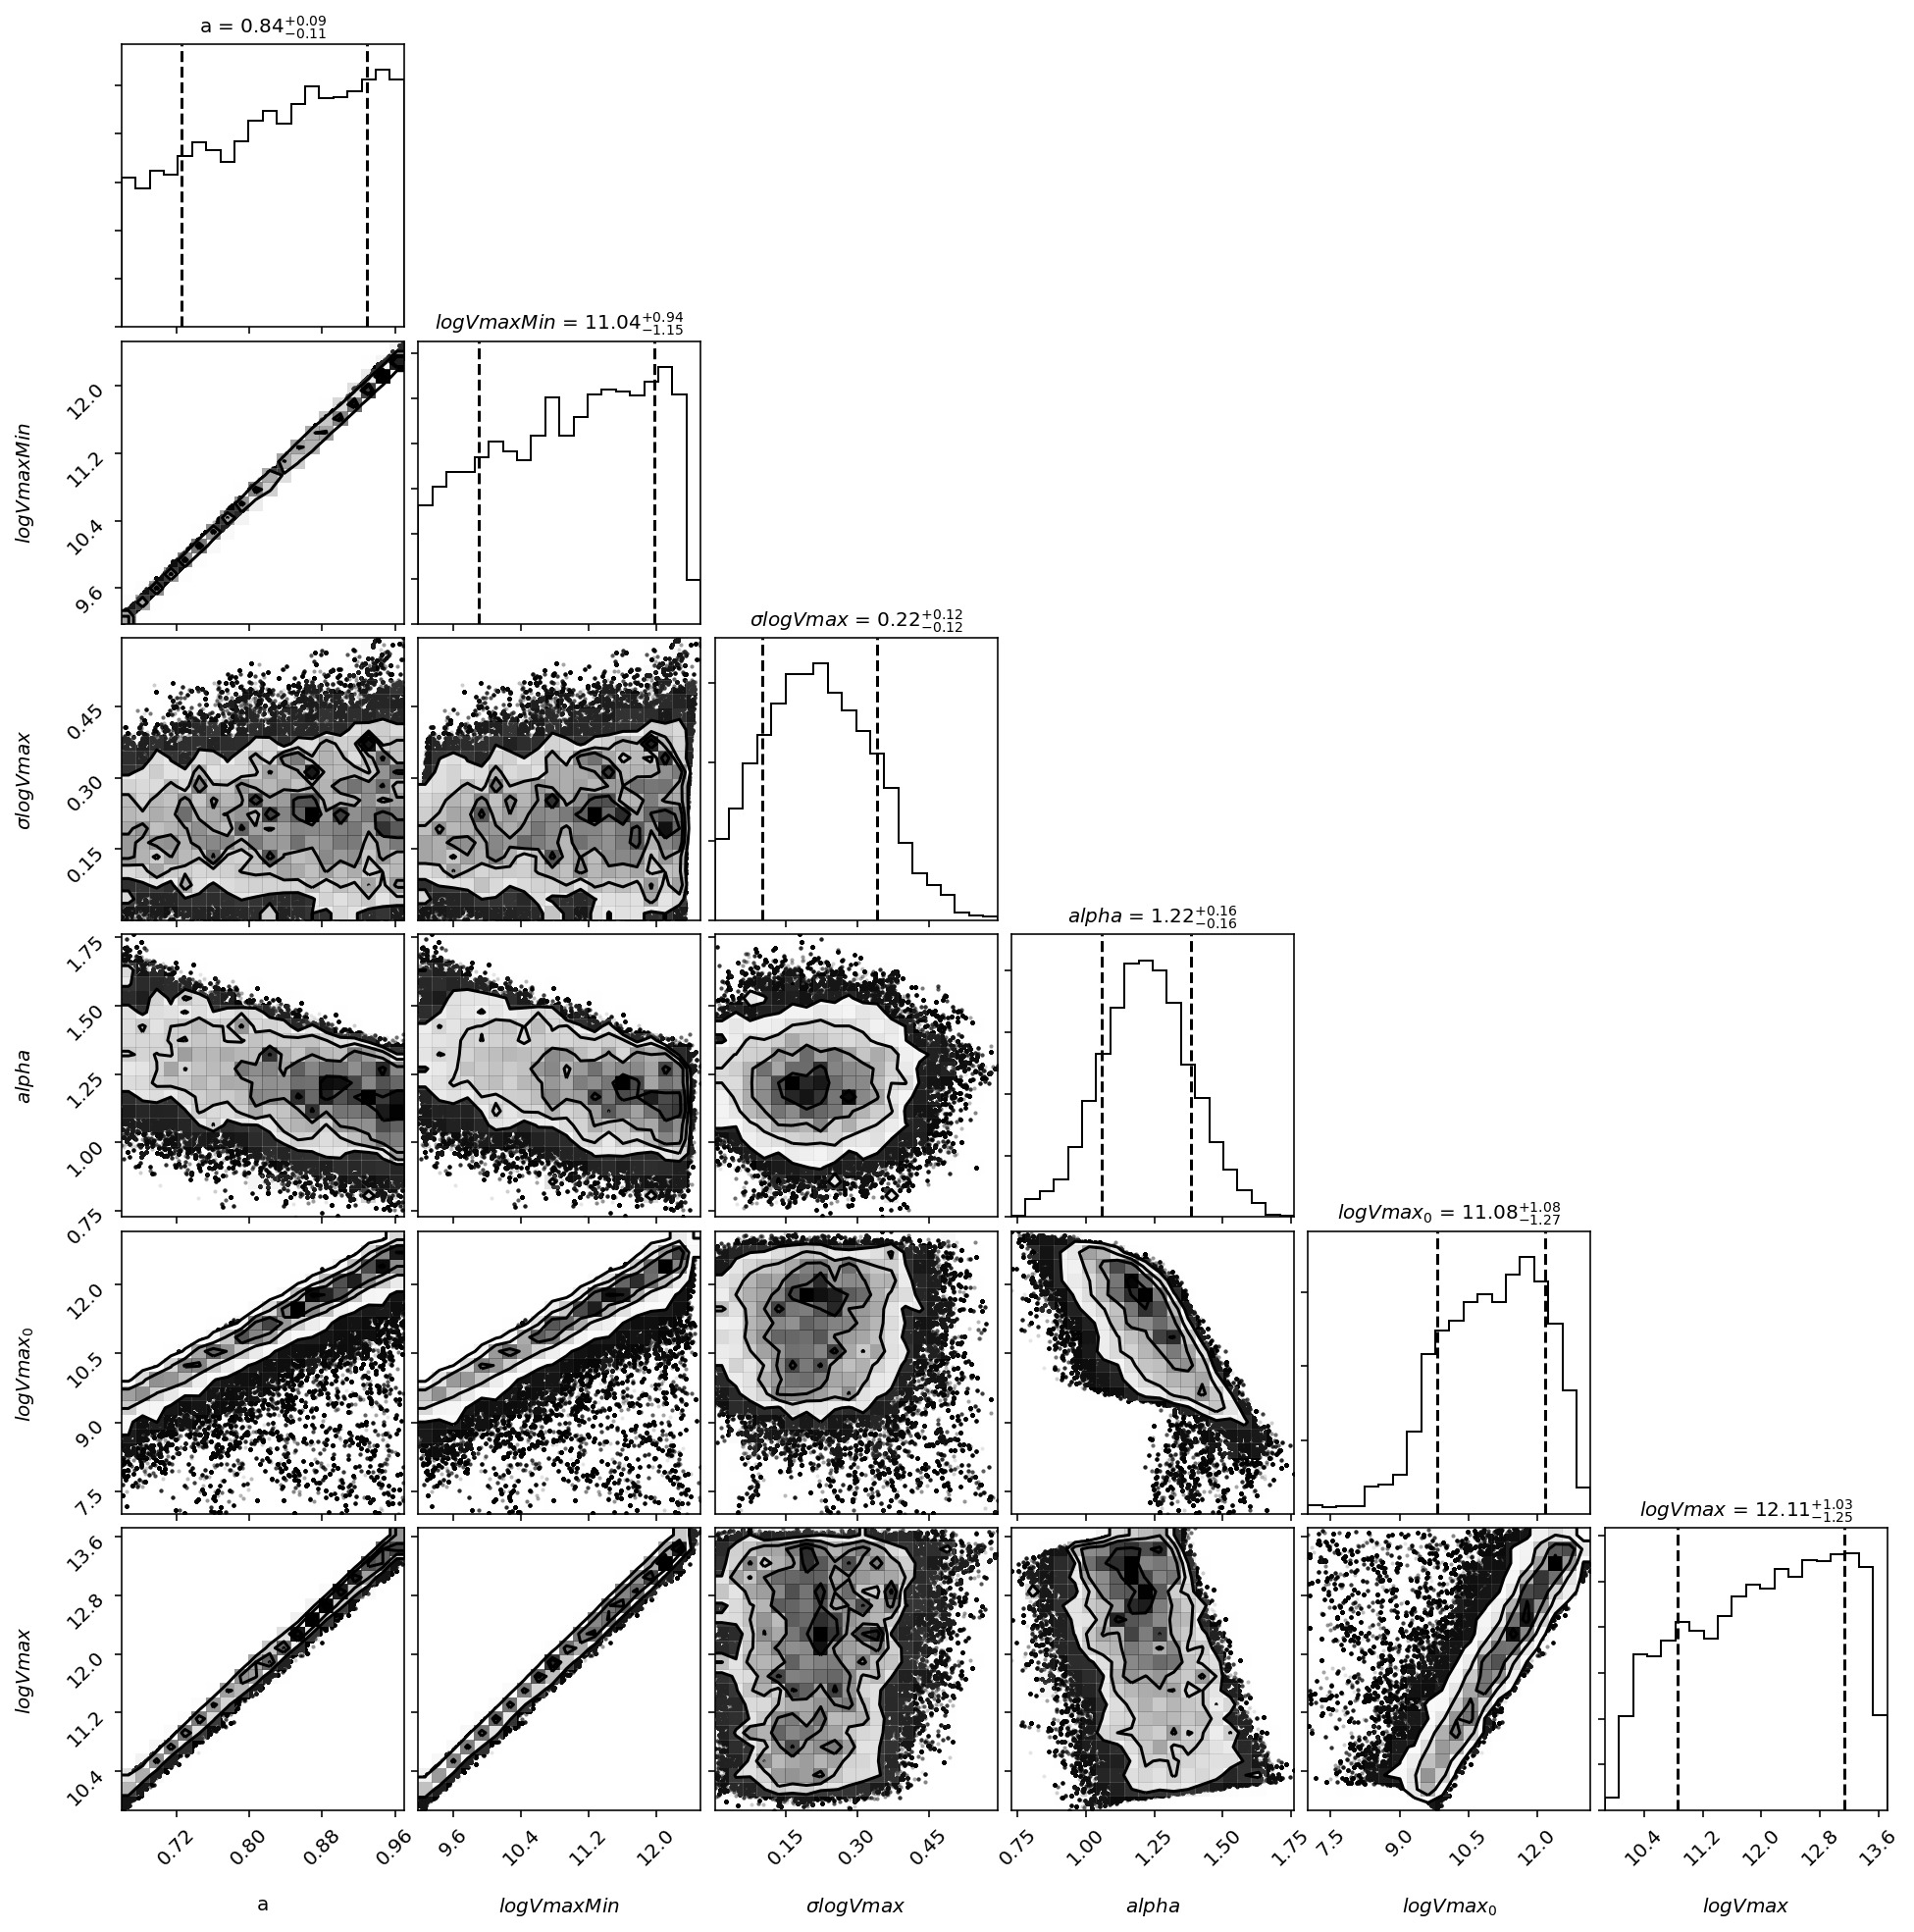

In [68]:
ndim=6
fig = corner.corner(samples.reshape(74000*35,6)[cut1][cut2],
        labels=["a","$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},quantiles=(0.16, 0.84))#, levels=(1-np.exp(-0.5),))


In [69]:
cut_min = chi2 == np.min(-2*log_prob_samples.reshape(74000*35)[cut1][cut2])
len(chi2)


1662675

In [70]:
samples.reshape((74000*35,6))[cut1][cut2][cut_min]

array([[ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       ...,
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ]])

In [444]:
np.shape(cut_min)

(1955578,)